# Couette Flow

Tutorial adapted from Anders Logg and Hans Petter Langtangen 
More details on equation derivations and reference at   
https://jsdokken.com/dolfinx-tutorial/chapter2/navierstokes.html  

## Problem Definition

This type of fluid flow through a channel is known as Couette flow. In this case, the horizontal flow is driven by a moving plate and a stationary plate. The flow is expected to result in linear flow pattern.



## Import Step

In [224]:

from mpi4py import MPI  # for parallel
from petsc4py import PETSc # matrix solver library
import numpy as np # for array manipulation
import pyvista # visualization

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical # define constants and functions, boundary conditions, 
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc # assemble matrix equations, apply and enforce BC
from dolfinx.io import VTXWriter # write to VTX
from dolfinx.mesh import create_unit_square # create square mesh
from dolfinx.plot import vtk_mesh # plot VTK mesh
from basix.ufl import element # make elements
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction, # face normal vector, identity matrix, test and trial functions
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym) # descirbe the variational form symbolically. math terms



## Create Mesh

In [225]:

mesh = create_unit_square(MPI.COMM_WORLD, 5, 5) # create 10x10 element square
t = 0 # initial time
T = 10 # total simulation time
num_steps = 500 # number of timesteps
dt = T / num_steps # calculate timestep 


## Define Function Spaces and Trial Functions

In [226]:
# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)


## Set Boundary Conditions

In [227]:
# *** DEFINE BOUNDARY CONDITIONS *** #

def topwall(x): # define where the walls are
    return np.array(np.isclose(x[1], 0))
def botwall(x): # define where the walls are
    return np.array( np.isclose(x[0], 0))

wall_dofs = locate_dofs_geometrical(V, topwall) # find the dofs on the walls
u_noslip = np.array((1,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0

wall_dofs1 = locate_dofs_geometrical(V, botwall) # find the dofs on the walls
u_noslip1 = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip1 = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0



def inflow(x): # define where the inlet is
    return np.isclose([0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow) # find dofs at the inlet
bc_inflow = dirichletbc(PETSc.ScalarType(4), inflow_dofs, Q) # assign Dirichlet BC at inlet dofs, p = 8, scalar



def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow) # find dofs at the outlet
bc_outflow = dirichletbc(PETSc.ScalarType(4), outflow_dofs, Q) # assign Dirichlet BC at outlet dofs, p = 0, scalar



bcu = [bc_noslip, bc_noslip1]
bcp = [bc_inflow, bc_outflow]

## Define Constants and Other Variables

In [228]:
# *** DEFINE CONSTANTS/VARIABLES *** #

n = FacetNormal(mesh) # normal vector
# define parameters as constants (dolphinx function)
f = Constant(mesh, PETSc.ScalarType((0, 0))) # additional body forces (none here)
k = Constant(mesh, PETSc.ScalarType(dt)) # timestep
mu = Constant(mesh, PETSc.ScalarType(1)) # viscosity
rho = Constant(mesh, PETSc.ScalarType(1)) # density

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

## Set up Variational Forms  

In [229]:
# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  
u_n.name = "u_n" 
U = 1* (u_n + u) 

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) 
p_n.name = "p_n" 
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx 
a1 = form(lhs(F1)) 
L1 = form(rhs(F1)) 

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) 
A1.assemble()
b1 = create_vector(L1) 

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) 
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) 
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) 
A2 = assemble_matrix(a2, bcs=bcp) 
A2.assemble()
b2 = create_vector(L2) 

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) 
a3 = form(rho * dot(u, v) * dx) 
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) 
A3 = assemble_matrix(a3) 
A3.assemble() 
b3 = create_vector(L3) 



## Solver Set Up

In [230]:
# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) 
solver1.setOperators(A1) 
solver1.setType(PETSc.KSP.Type.BCGS) 
pc1 = solver1.getPC() 
pc1.setType(PETSc.PC.Type.HYPRE) 
pc1.setHYPREType("boomeramg") 

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) 
solver2.setOperators(A2) 
solver2.setType(PETSc.KSP.Type.BCGS) 
pc2 = solver2.getPC() 
pc2.setType(PETSc.PC.Type.HYPRE) 
pc2.setHYPREType("boomeramg") 

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) 
solver3.setOperators(A3) 
solver3.setType(PETSc.KSP.Type.CG) 
pc3 = solver3.getPC() 
pc3.setType(PETSc.PC.Type.SOR) 


## Prepare Output Files

In [231]:
from pathlib import Path 
folder = Path("results") 
folder.mkdir(exist_ok=True, parents=True) 
vtx_u = VTXWriter(mesh.comm, folder / "couette_u.bp", u_n, engine="BP4")  
vtx_p = VTXWriter(mesh.comm, folder / "couette_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t) 

## Analytic Solution

In [232]:
# ** ANALYTIC SOLUTION *** #

def u_exact(x): # analytic solution function
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType) 
    values[0] = 1 * x[1] # 
    return values


u_ex = Function(V) 
u_ex.interpolate(u_exact) 

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx) # find error 

## Solve

In [233]:
# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu]) 
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b1, bcu)
    solver1.solve(b1, u_.x.petsc_vec) 
    u_.x.scatter_forward() 

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) 
    apply_lifting(b2, [a2], [bcp]) 
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b2, bcp) 
    solver2.solve(b2, p_.x.petsc_vec) 
    p_.x.scatter_forward() 

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) 
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    solver3.solve(b3, u_.x.petsc_vec) 
    u_.x.scatter_forward() 
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")

vtx_u.close()
vtx_p.close()

b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()


Time 0.02, L2-error 7.52e-01, Max error 2.76e+00
Time 0.42, L2-error 1.17e+00, Max error 1.05e+00
Time 0.82, L2-error 1.16e+00, Max error 1.03e+00
Time 1.22, L2-error 1.15e+00, Max error 1.02e+00
Time 1.62, L2-error 1.15e+00, Max error 1.01e+00
Time 2.02, L2-error 1.15e+00, Max error 1.01e+00
Time 2.42, L2-error 1.15e+00, Max error 1.00e+00
Time 2.82, L2-error 1.15e+00, Max error 1.00e+00
Time 3.22, L2-error 1.15e+00, Max error 1.00e+00
Time 3.62, L2-error 1.15e+00, Max error 1.00e+00
Time 4.02, L2-error 1.15e+00, Max error 1.00e+00
Time 4.42, L2-error 1.15e+00, Max error 1.00e+00
Time 4.82, L2-error 1.15e+00, Max error 1.00e+00
Time 5.22, L2-error 1.15e+00, Max error 1.00e+00
Time 5.62, L2-error 1.15e+00, Max error 1.00e+00
Time 6.02, L2-error 1.15e+00, Max error 1.00e+00
Time 6.42, L2-error 1.15e+00, Max error 1.00e+00
Time 6.82, L2-error 1.15e+00, Max error 1.00e+00
Time 7.22, L2-error 1.15e+00, Max error 1.00e+00
Time 7.62, L2-error 1.15e+00, Max error 1.00e+00
Time 8.02, L2-error 


## Visualization Step

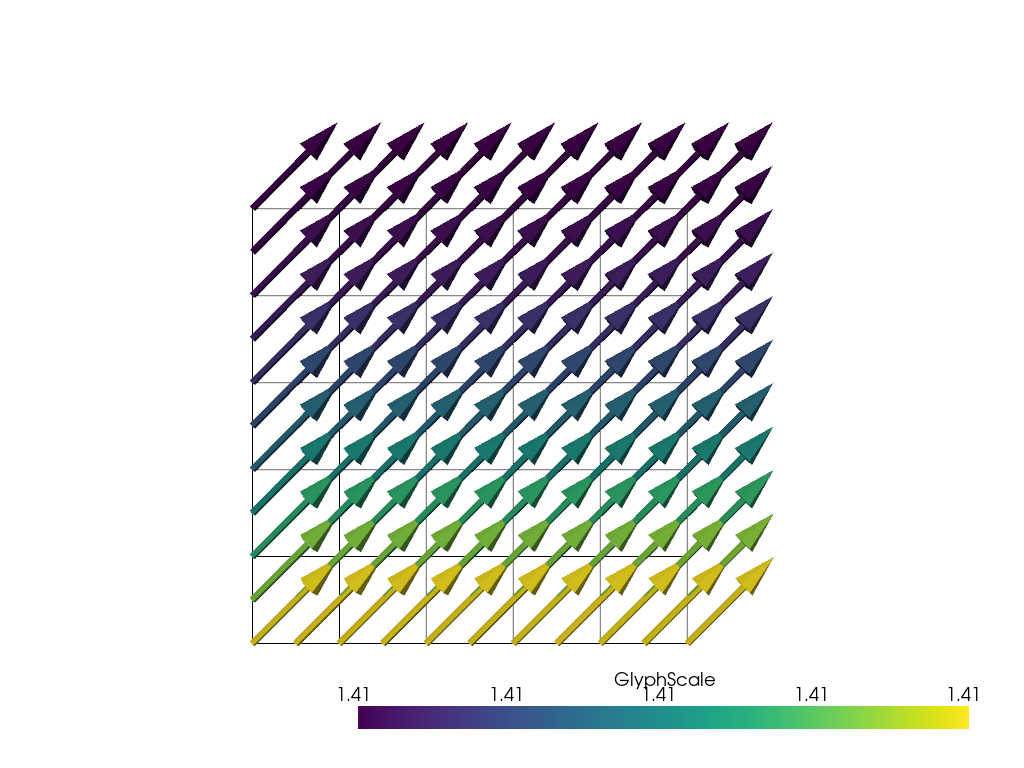

In [234]:
# *** VISUALIZATION *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")

## Mech Refinement 

This analysis will refine the mesh

The sections for the solver are combined for use, with visualization separated at the end. 

In [235]:
#Regenerate mesh

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10) # create 10x10 element square
t = 0 # initial time
T = 10 # total simulation time
num_steps = 500 # number of timesteps
dt = T / num_steps # calculate timestep 

## This section will execute the entirety of the solver; combined for user ease. The visualization is to be run in the next cell. 

In [240]:
# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)



# *** DEFINE BOUNDARY CONDITIONS *** #

def topwall(x): # define where the walls are
    return np.array(np.isclose(x[1], 0))
def botwall(x): # define where the walls are
    return np.array( np.isclose(x[0], 0))

wall_dofs = locate_dofs_geometrical(V, topwall) # find the dofs on the walls
u_noslip = np.array((1,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0

wall_dofs1 = locate_dofs_geometrical(V, botwall) # find the dofs on the walls
u_noslip1 = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip1 = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0



def inflow(x): # define where the inlet is
    return np.isclose([0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow) # find dofs at the inlet
bc_inflow = dirichletbc(PETSc.ScalarType(4), inflow_dofs, Q) # assign Dirichlet BC at inlet dofs, p = 8, scalar



def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow) # find dofs at the outlet
bc_outflow = dirichletbc(PETSc.ScalarType(4), outflow_dofs, Q) # assign Dirichlet BC at outlet dofs, p = 0, scalar



bcu = [bc_noslip, bc_noslip1]
bcp = [bc_inflow, bc_outflow]

# *** DEFINE CONSTANTS/VARIABLES *** #

n = FacetNormal(mesh) # normal vector
# define parameters as constants (dolphinx function)
f = Constant(mesh, PETSc.ScalarType((0, 0))) # additional body forces (none here)
k = Constant(mesh, PETSc.ScalarType(dt)) # timestep
mu = Constant(mesh, PETSc.ScalarType(1)) # viscosity
rho = Constant(mesh, PETSc.ScalarType(1)) # density

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))


# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  
u_n.name = "u_n" 
U = 1* (u_n + u) 

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) 
p_n.name = "p_n" 
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx 
a1 = form(lhs(F1)) 
L1 = form(rhs(F1)) 

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) 
A1.assemble()
b1 = create_vector(L1) 

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) 
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) 
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) 
A2 = assemble_matrix(a2, bcs=bcp) 
A2.assemble()
b2 = create_vector(L2) 

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) 
a3 = form(rho * dot(u, v) * dx) 
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) 
A3 = assemble_matrix(a3) 
A3.assemble() 
b3 = create_vector(L3) 

# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) 
solver1.setOperators(A1) 
solver1.setType(PETSc.KSP.Type.BCGS) 
pc1 = solver1.getPC() 
pc1.setType(PETSc.PC.Type.HYPRE) 
pc1.setHYPREType("boomeramg") 

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) 
solver2.setOperators(A2) 
solver2.setType(PETSc.KSP.Type.BCGS) 
pc2 = solver2.getPC() 
pc2.setType(PETSc.PC.Type.HYPRE) 
pc2.setHYPREType("boomeramg") 

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) 
solver3.setOperators(A3) 
solver3.setType(PETSc.KSP.Type.CG) 
pc3 = solver3.getPC() 
pc3.setType(PETSc.PC.Type.SOR) 



from pathlib import Path 
folder = Path("results") 
folder.mkdir(exist_ok=True, parents=True) 
vtx_u = VTXWriter(mesh.comm, folder / "couette_u.bp", u_n, engine="BP4")  
vtx_p = VTXWriter(mesh.comm, folder / "couette_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t) 

# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu]) 
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b1, bcu)
    solver1.solve(b1, u_.x.petsc_vec) 
    u_.x.scatter_forward() 

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) 
    apply_lifting(b2, [a2], [bcp]) 
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b2, bcp) 
    solver2.solve(b2, p_.x.petsc_vec) 
    p_.x.scatter_forward() 

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) 
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    solver3.solve(b3, u_.x.petsc_vec) 
    u_.x.scatter_forward() 
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]




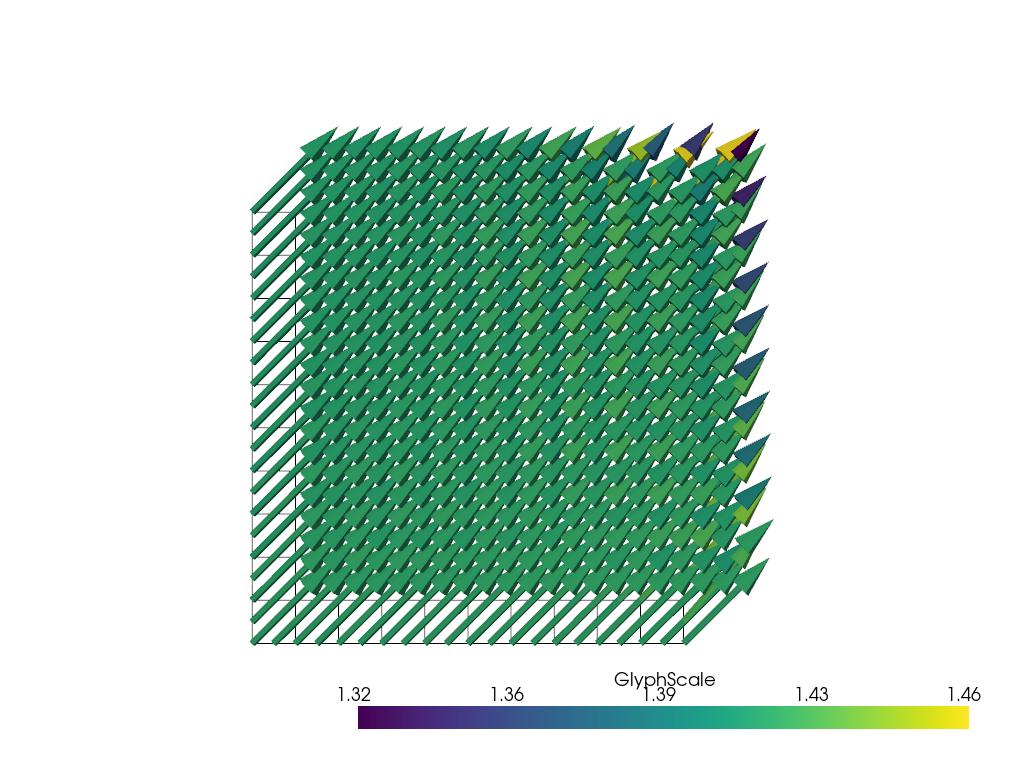

In [241]:
# *** VISUALIZATION *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")

## Failed Solver

This example only evaluates the solver, as the setup is expected to fail based on the inputs provided. 

The issue here will be the initial velocity guess will be set to zero, and will fail to converge. 

In [244]:
# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)



# *** DEFINE BOUNDARY CONDITIONS *** #

def topwall(x): # define where the walls are
    return np.array(np.isclose(x[1], 0))
def botwall(x): # define where the walls are
    return np.array( np.isclose(x[0], 0))

wall_dofs = locate_dofs_geometrical(V, topwall) # find the dofs on the walls
u_noslip = np.array((1,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0

wall_dofs1 = locate_dofs_geometrical(V, botwall) # find the dofs on the walls
u_noslip1 = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip1 = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0



def inflow(x): # define where the inlet is
    return np.isclose([0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow) # find dofs at the inlet
bc_inflow = dirichletbc(PETSc.ScalarType(4), inflow_dofs, Q) # assign Dirichlet BC at inlet dofs, p = 8, scalar



def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow) # find dofs at the outlet
bc_outflow = dirichletbc(PETSc.ScalarType(4), outflow_dofs, Q) # assign Dirichlet BC at outlet dofs, p = 0, scalar



bcu = [bc_noslip, bc_noslip1]
bcp = [bc_inflow, bc_outflow]

# *** DEFINE CONSTANTS/VARIABLES *** #

n = FacetNormal(mesh) # normal vector
# define parameters as constants (dolphinx function)
f = Constant(mesh, PETSc.ScalarType((0, 0))) # additional body forces (none here)
k = Constant(mesh, PETSc.ScalarType(dt)) # timestep
mu = Constant(mesh, PETSc.ScalarType(1)) # viscosity
rho = Constant(mesh, PETSc.ScalarType(1)) # density

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))


# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  
u_n.name = "u_n" 
U = 0* (u_n + u) 

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) 
p_n.name = "p_n" 
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx 
a1 = form(lhs(F1)) 
L1 = form(rhs(F1)) 

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) 
A1.assemble()
b1 = create_vector(L1) 

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) 
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) 
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) 
A2 = assemble_matrix(a2, bcs=bcp) 
A2.assemble()
b2 = create_vector(L2) 

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) 
a3 = form(rho * dot(u, v) * dx) 
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) 
A3 = assemble_matrix(a3) 
A3.assemble() 
b3 = create_vector(L3) 

# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) 
solver1.setOperators(A1) 
solver1.setType(PETSc.KSP.Type.BCGS) 
pc1 = solver1.getPC() 
pc1.setType(PETSc.PC.Type.HYPRE) 
pc1.setHYPREType("boomeramg") 

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) 
solver2.setOperators(A2) 
solver2.setType(PETSc.KSP.Type.BCGS) 
pc2 = solver2.getPC() 
pc2.setType(PETSc.PC.Type.HYPRE) 
pc2.setHYPREType("boomeramg") 

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) 
solver3.setOperators(A3) 
solver3.setType(PETSc.KSP.Type.CG) 
pc3 = solver3.getPC() 
pc3.setType(PETSc.PC.Type.SOR) 



from pathlib import Path 
folder = Path("results") 
folder.mkdir(exist_ok=True, parents=True) 
vtx_u = VTXWriter(mesh.comm, folder / "couette_u.bp", u_n, engine="BP4")  
vtx_p = VTXWriter(mesh.comm, folder / "couette_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t) 

# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu]) 
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b1, bcu)
    solver1.solve(b1, u_.x.petsc_vec) 
    u_.x.scatter_forward() 

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) 
    apply_lifting(b2, [a2], [bcp]) 
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b2, bcp) 
    solver2.solve(b2, p_.x.petsc_vec) 
    p_.x.scatter_forward() 

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) 
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    solver3.solve(b3, u_.x.petsc_vec) 
    u_.x.scatter_forward() 
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]



ValueError: Cannot determine geometric dimension from expression.